# 0. Libraries

In [1]:
import sys
sys.path.append('../')  # Add parent directory to path

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hw1_library import feature_engineering

[Geopandas documentation](https://geopandas.org/en/stable/docs.html).

# 1. LDA topic share by US state

## 1.1. Ben's instructions

Please find attached a zipfile that contains:

- `us_adm2`: This contains the shapefile for the US at the ADM2 level. The boundaries are sourced from https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM2.zip
- `us_text.parquet`: This contains the raw LDA topic shares for the US from 201701 to 202503 at the ADM2 level. Please note the below as it is important.

I am providing the data at the article level. This is quite different to the data we gave you in class (which was after applying the stock computation we discussed). To jog your memory, you can check slide 22 of session_3. I am giving you the outputs as per the first bullet point here [‘article_id’, ‘date’, ‘isocode’, ‘tokens’, ‘pr_topic_0’, …, ‘pr_topic_14’]. Note that I am giving you the data at the period (YYYYMM) not date (YYYYMMDD) level.

In other words, you need to decide on an aggregation step that goes from the shapeID-article-period level to the shapeID-period level. Below is what we do:

```{python}
class AggregateText:
    def __init__(self, df, unit_col, time_col):
        self.unit = unit_col
        self.time = time_col
        self.df = df
    
    def _get_topic_cols(self):
        self.pr_topic_cols = self.df.columns[self.df.columns.str.contains('pr_topic')]

    def GroupbyAgg(self):
        self._get_topic_cols()
        agg_dict = {col:'mean' for col in self.pr_topic_cols}
        agg_dict.update({'tokens':'sum', 'article_id':'count'})
        self.df = self.df.groupby([self.unit, self.time]).agg(agg_dict).rename(columns={'article_id':'article_count'})
        return self.df
```

But you could get funkier by trying something other than the mean, or applying the stock computation we talked about in class.

## 1.2. Loading the data

First, we load a list with the abbreviations for the US states (excluding outer territories but including the District of Columbia). [Source](https://gist.github.com/JeffPaine/3083347).

In [6]:
df_lda = pd.read_parquet('../../lda_articles_US/us_text.parquet')

print(f'Number of articles: {len(df_lda)}')

df_lda.head()

Number of articles: 721321


,shapeID,period,article_id,tokens,pr_topic_0,pr_topic_1,pr_topic_2,pr_topic_3,pr_topic_4,pr_topic_5,pr_topic_6,pr_topic_7,pr_topic_8,pr_topic_9,pr_topic_10,pr_topic_11,pr_topic_12,pr_topic_13,pr_topic_14
0,52423323B10055621117527,201709,4447929.0,205.0,0.000346,0.000346,0.000346,0.101811,0.000346,0.049830,0.357571,0.089329,0.008701,0.000346,0.063960,0.118805,0.194406,0.000346,0.013513
1,52423323B10055621117527,201709,4447930.0,205.0,0.000346,0.000346,0.000346,0.101811,0.000346,0.049830,0.357562,0.089329,0.008701,0.000346,0.063958,0.118805,0.194404,0.000346,0.013526
2,52423323B10055621117527,201710,4460775.0,267.0,0.000264,0.000264,0.026536,0.000264,0.000264,0.004561,0.230516,0.374741,0.061971,0.000264,0.000264,0.020164,0.242891,0.000264,0.036773
3,52423323B10055621117527,201710,4461787.0,100.0,0.000738,0.397948,0.051768,0.000738,0.088460,0.000738,0.000738,0.000738,0.376365,0.000738,0.000738,0.000738,0.078077,0.000738,0.000738
4,52423323B10055621117527,201806,4566984.0,355.0,0.000212,0.205195,0.017569,0.181397,0.064282,0.152234,0.000212,0.157289,0.000212,0.007841,0.032546,0.000212,0.080258,0.014935,0.085605


In [ ]:
# Load the boundaries of the US counties (ADM2)
counties_gdf = gpd.read_file('../../lda_articles_US/geoBoundariesCGAZ_ADM2/geoBoundariesCGAZ_ADM2.shp')

# Filter the counties to only include those in the US
counties_gdf = counties_gdf[counties_gdf['shapeGroup'] == 'USA']

# Check the projection of the counties
print(f'Projection of the geometries of the US counties: {counties_gdf.crs}')

print(f'Number of counties: {len(counties_gdf)}')

counties_gdf.head()

Projection of the geometries of the US counties: EPSG:4326
Number of counties: 3231


,shapeName,shapeID,shapeGroup,shapeType,geometry
698,Highland,52423323B51867153498623,USA,ADM2,"POLYGON ((-83.86568 39.24734, -83.7848 39.2629..."
699,Alpine,52423323B67588574079428,USA,ADM2,"POLYGON ((-120.0725 38.50987, -120.0724 38.702..."
700,Escambia,52423323B97123089850170,USA,ADM2,"MULTIPOLYGON (((-87.59883 30.99743, -87.16362 ..."
701,Lawrence,52423323B54167037237770,USA,ADM2,"POLYGON ((-87.90812 38.85011, -87.53436 38.852..."
702,Wayne,52423323B18579387327768,USA,ADM2,"POLYGON ((-88.94336 31.82457, -88.91046 31.826..."


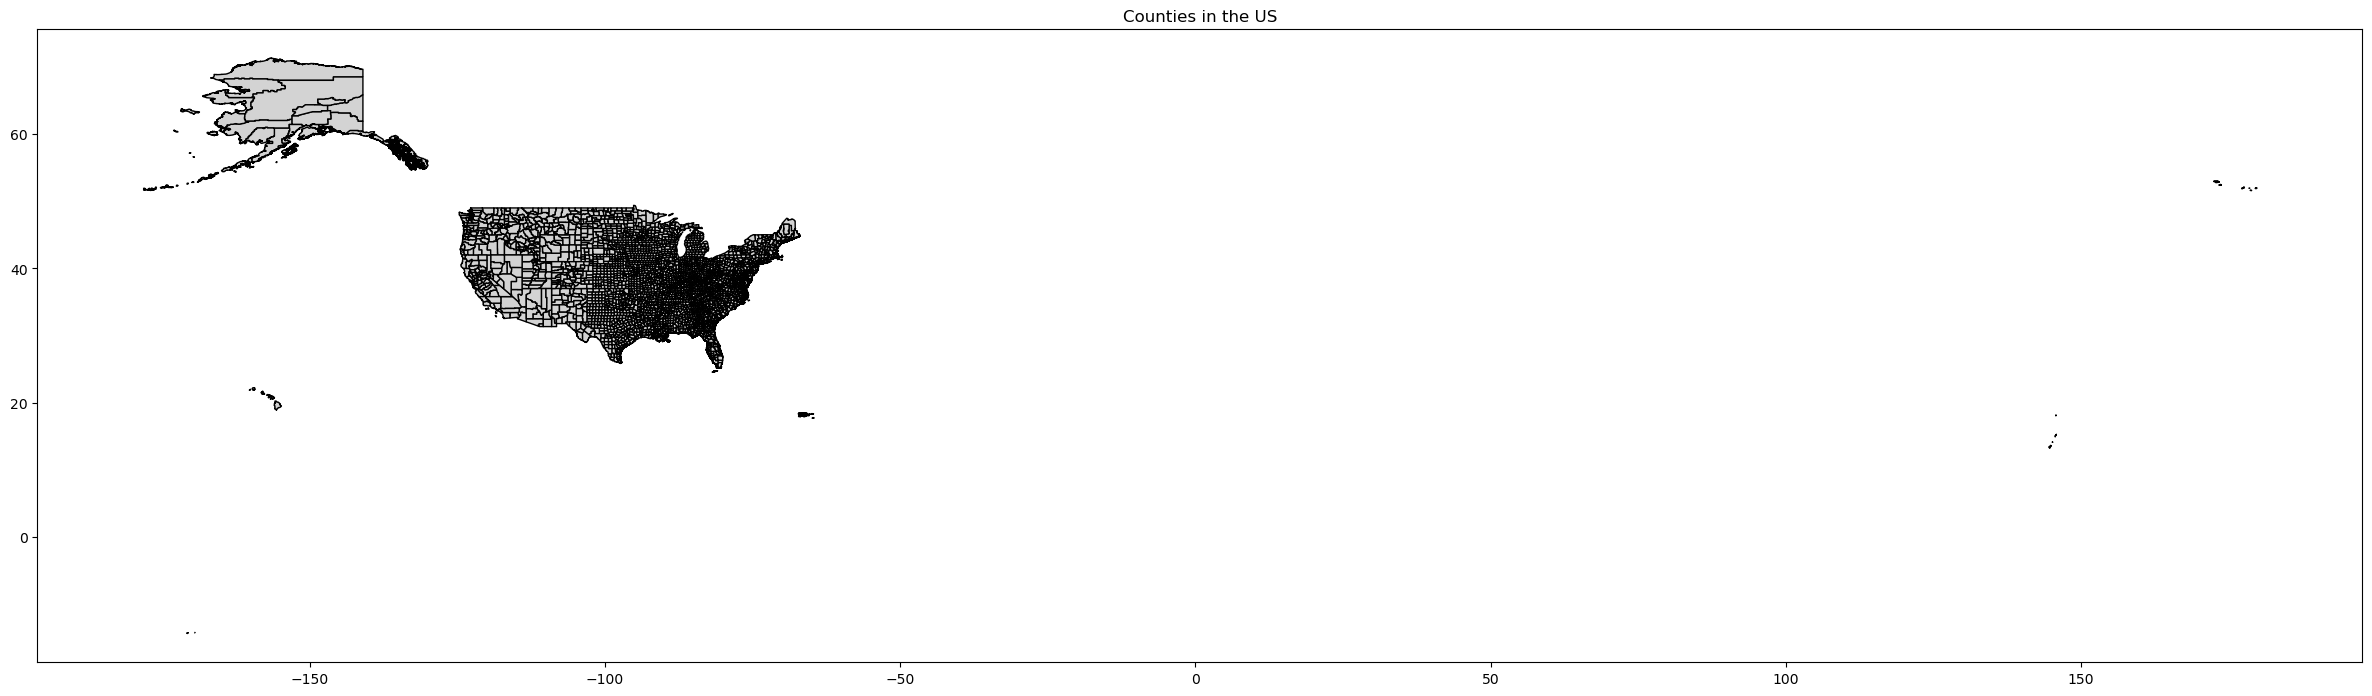

In [74]:
# Plot the counties
fig, ax = plt.subplots(figsize=(30, 30))
counties_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
ax.set_title('Counties in the US')
plt.show()

Since several county names are repeated across the United States for different states, we have to work with the county geometries and the state geometries in order to assign a US state to each county. 

Therefore, we also need the polygons for the US states, so that the counties within a certain state are assigned to that state. [Source: US NOAA](https://www.weather.gov/gis/USStates). 

Useful information:
- On projections.
- On [spatial joins](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins) and the [`geopandas.GeoDataFrame.sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) method.

In [ ]:
# Load the US states shapefile
states_gdf = gpd.read_file('../../US_state_boundaries/s_18mr25.shp')

# Check the projection of the states
print(states_gdf.crs)

print(f'Number of states (including outer territories): {len(states_gdf)}')

states_gdf.head()

EPSG:4269
Number of states (including outer territories): 59


,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.4909 37.00361, -110.4875 37.002..."
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.4262 32.79973, -118.42634..."


In [76]:
# Keep only the columns we need
states_gdf = states_gdf[['STATE', 'geometry']]

# Rename the columns
states_gdf = states_gdf.rename(columns={'STATE': 'state'})

# Change the projection to WGS 84 (4326)
states_gdf = states_gdf.to_crs(epsg=4326)

print(f'Projection of the geometries of the US states: {states_gdf.crs}')

Projection of the geometries of the US states: EPSG:4326


Text(0.5, 1.0, 'States in the US')

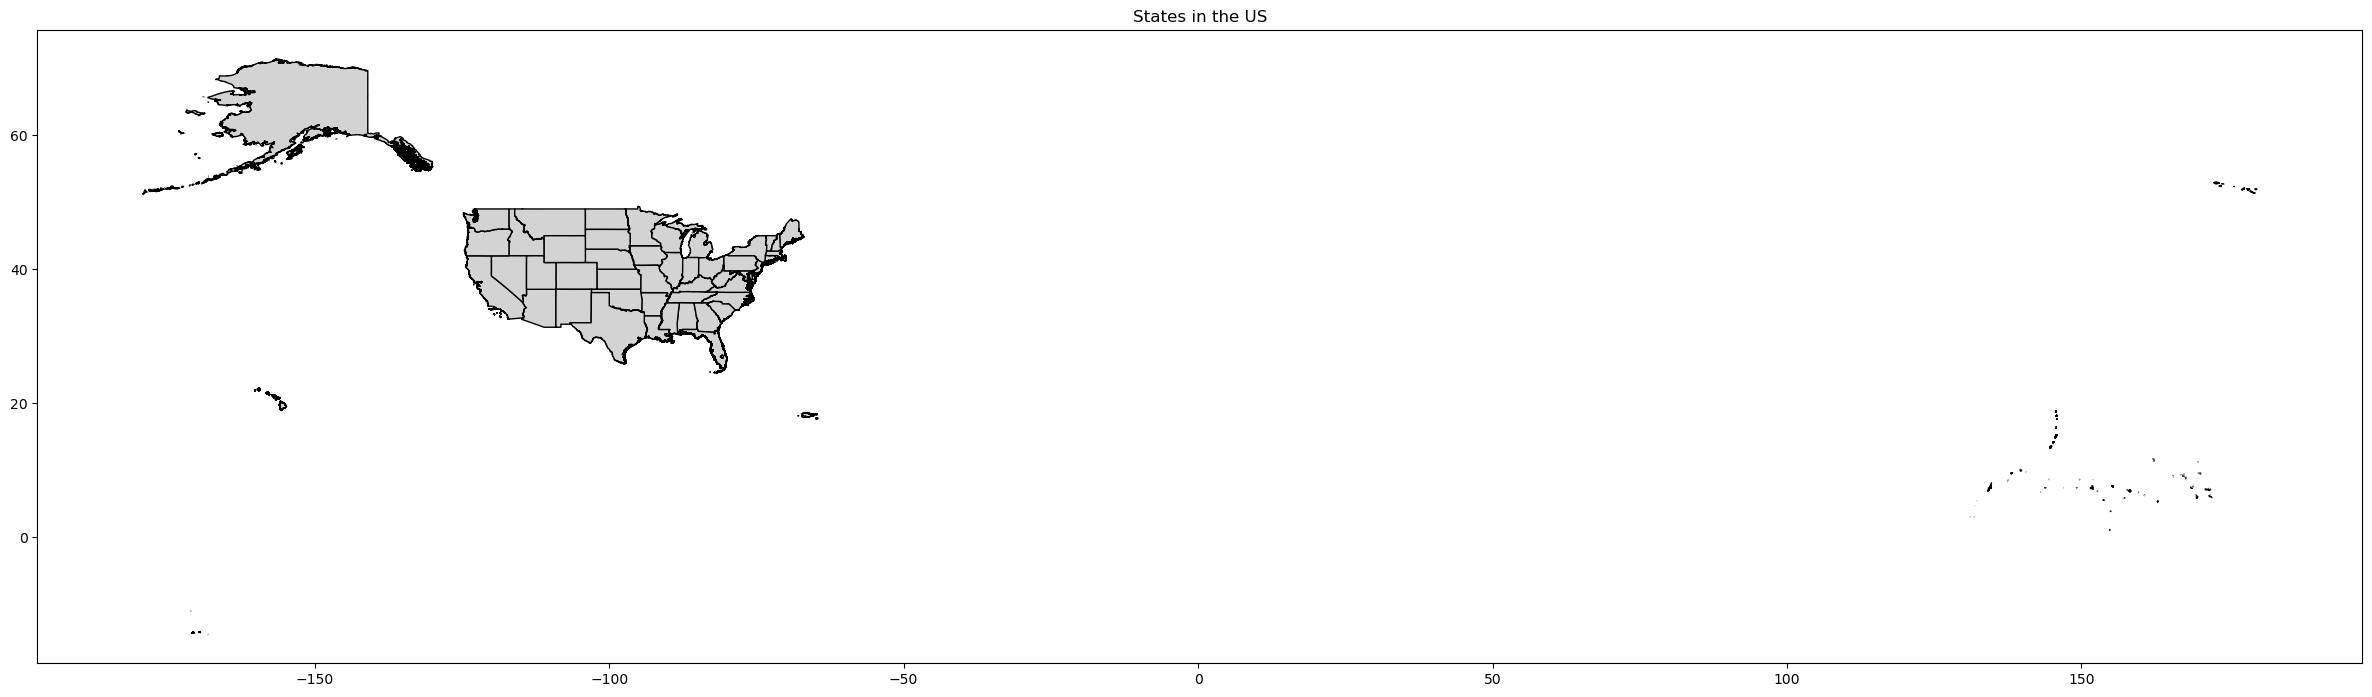

In [77]:
# Plot the states
fig, ax = plt.subplots(figsize=(30, 30))
states_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
ax.set_title('States in the US')

Below, we do the spatial join with the centroid since the boundaries of the counties can be bordering two (or more) US states, which can cause that the number of resulting counties is larger than the original number (as a county is matched to more than one state).

In [78]:
# Re-project first for calculating the centroid to a flat coordinate system
counties_gdf['centroid'] = counties_gdf.geometry.to_crs(crs='EPSG:5070').centroid.to_crs(crs='EPSG:4326')

counties_gdf.head()

,shapeName,shapeID,shapeGroup,shapeType,geometry,centroid
698,Highland,52423323B51867153498623,USA,ADM2,"POLYGON ((-83.86568 39.24734, -83.7848 39.2629...",POINT (-83.60567 39.18591)
699,Alpine,52423323B67588574079428,USA,ADM2,"POLYGON ((-120.0725 38.50987, -120.0724 38.702...",POINT (-119.81765 38.5975)
700,Escambia,52423323B97123089850170,USA,ADM2,"MULTIPOLYGON (((-87.59883 30.99743, -87.16362 ...",POINT (-87.37976 30.69611)
701,Lawrence,52423323B54167037237770,USA,ADM2,"POLYGON ((-87.90812 38.85011, -87.53436 38.852...",POINT (-87.72821 38.72061)
702,Wayne,52423323B18579387327768,USA,ADM2,"POLYGON ((-88.94336 31.82457, -88.91046 31.826...",POINT (-88.69642 31.64186)


In [79]:
# Merge the two dataframes based on the centroid of the counties (if the centroid 
# of a county is within a state, assign it to that state
counties_centroid = counties_gdf.copy()
counties_centroid.geometry = counties_centroid['centroid']
merged_gdf = counties_centroid.sjoin(states_gdf, how='left', predicate='within')

print('Number of counties after the merge (should be equal to the counties before the merge):', len(merged_gdf))

merged_gdf.head()

Number of counties after the merge (should be equal to the counties before the merge): 3231


,shapeName,shapeID,shapeGroup,shapeType,geometry,centroid,index_right,state
698,Highland,52423323B51867153498623,USA,ADM2,"POLYGON ((-83.86568 39.24734, -83.7848 39.2629...",POINT (-83.60567 39.18591),32.0,OH
699,Alpine,52423323B67588574079428,USA,ADM2,"POLYGON ((-120.0725 38.50987, -120.0724 38.702...",POINT (-119.81765 38.5975),4.0,CA
700,Escambia,52423323B97123089850170,USA,ADM2,"MULTIPOLYGON (((-87.59883 30.99743, -87.16362 ...",POINT (-87.37976 30.69611),57.0,FL
701,Lawrence,52423323B54167037237770,USA,ADM2,"POLYGON ((-87.90812 38.85011, -87.53436 38.852...",POINT (-87.72821 38.72061),13.0,IL
702,Wayne,52423323B18579387327768,USA,ADM2,"POLYGON ((-88.94336 31.82457, -88.91046 31.826...",POINT (-88.69642 31.64186),22.0,MS


Missing state for Aleutians West, shapeID: 52423323B14067598441828
Missing state for Ketchikan Gateway, shapeID: 52423323B88813000222889
Missing state for Hoonah-Angoon, shapeID: 52423323B82121365400499
Missing state for Kitsap, shapeID: 52423323B24057696547970
Missing state for Pinellas, shapeID: 52423323B48942229676406
Missing state for Island, shapeID: 52423323B81098999696635
Missing state for Kodiak Island, shapeID: 52423323B80008995120080
Missing state for Keweenaw, shapeID: 52423323B74408100948794
Missing state for Kenai Peninsula, shapeID: 52423323B64721050065013


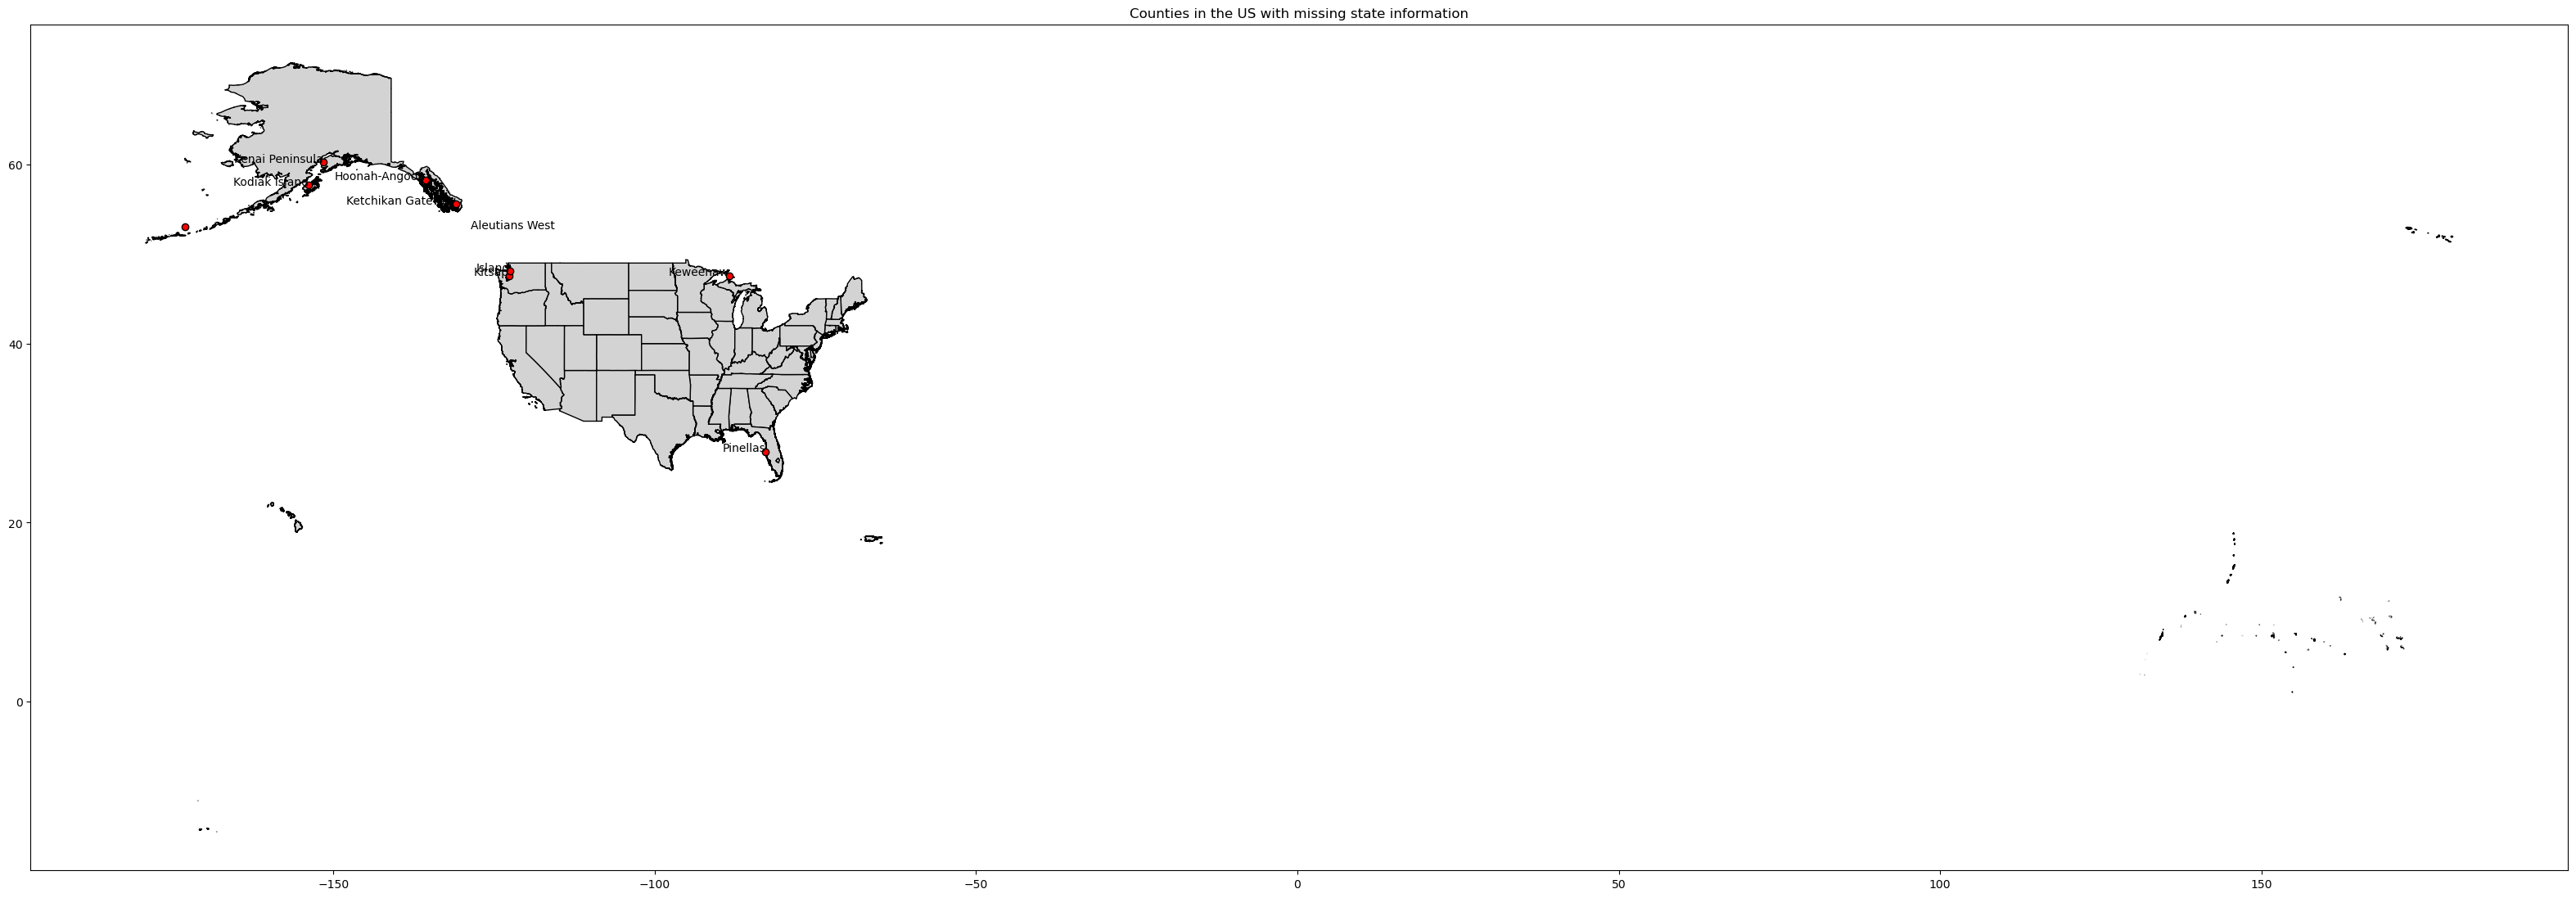

In [85]:
# Visualize the missing values in the state column, with the state geometries overlapped
# on top of the counties
fig, ax = plt.subplots(figsize=(40, 40))
states_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
merged_gdf[merged_gdf['state'].isna()].plot(ax=ax, color='red', edgecolor='black')
# Plot the shapeName for each of the counties with missing state information
for i, row in merged_gdf[merged_gdf['state'].isna()].iterrows():
    ax.annotate(row['shapeName'], xy=row.geometry.centroid.coords[0], fontsize=10, ha='right', color='black')
    print(f"Missing state for {row['shapeName']}, shapeID: {row['shapeID']}")
ax.set_title('Counties in the US with missing state information')
plt.show()

We can manually set the missing states for the counties that have been printed above.

In [93]:
# Counties in Alaska
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B14067598441828','state'] = 'AK'  # Aleutians west
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B88813000222889', 'state'] = 'AK'  # Ketchikan Gateway
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B82121365400499', 'state'] = 'AK'  # Hoonah-Angoon
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B80008995120080', 'state'] = 'AK'  # Kodia Island
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B64721050065013', 'state'] = 'AK'  # Kenai Peninsula

# Counties in Washington
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B24057696547970', 'state'] = 'WA'  # Kitsap
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B81098999696635', 'state'] = 'WA'  # Island

# Counties in Florida
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B48942229676406', 'state'] = 'FL'  # Pinellas

# Counties in Michigan
merged_gdf.loc[merged_gdf['shapeID'] == '52423323B74408100948794', 'state'] = 'MI'  # Keweenaw

In [94]:
merged_gdf.isna().sum()

shapeName      0
shapeID        0
shapeGroup     0
shapeType      0
geometry       0
centroid       0
index_right    9
state          0
dtype: int64

In [95]:
# Merge the LDA data frame with the merged_gdf data frame
df_lda_merged = df_lda.merge(merged_gdf[['shapeID', 'state']], left_on='shapeID', right_on='shapeID', how='left')

print(f'Number of articles after the merge (should be equal as before the merge): {len(df_lda_merged)}')

df_lda_merged.head()

Number of articles after the merge (should be equal as before the merge): 721321


,shapeID,period,article_id,tokens,pr_topic_0,pr_topic_1,pr_topic_2,pr_topic_3,pr_topic_4,pr_topic_5,pr_topic_6,pr_topic_7,pr_topic_8,pr_topic_9,pr_topic_10,pr_topic_11,pr_topic_12,pr_topic_13,pr_topic_14,state
0,52423323B10055621117527,201709,4447929.0,205.0,0.000346,0.000346,0.000346,0.101811,0.000346,0.049830,0.357571,0.089329,0.008701,0.000346,0.063960,0.118805,0.194406,0.000346,0.013513,SC
1,52423323B10055621117527,201709,4447930.0,205.0,0.000346,0.000346,0.000346,0.101811,0.000346,0.049830,0.357562,0.089329,0.008701,0.000346,0.063958,0.118805,0.194404,0.000346,0.013526,SC
2,52423323B10055621117527,201710,4460775.0,267.0,0.000264,0.000264,0.026536,0.000264,0.000264,0.004561,0.230516,0.374741,0.061971,0.000264,0.000264,0.020164,0.242891,0.000264,0.036773,SC
3,52423323B10055621117527,201710,4461787.0,100.0,0.000738,0.397948,0.051768,0.000738,0.088460,0.000738,0.000738,0.000738,0.376365,0.000738,0.000738,0.000738,0.078077,0.000738,0.000738,SC
4,52423323B10055621117527,201806,4566984.0,355.0,0.000212,0.205195,0.017569,0.181397,0.064282,0.152234,0.000212,0.157289,0.000212,0.007841,0.032546,0.000212,0.080258,0.014935,0.085605,SC


## 1.3. Aggregating LDA topic share per article

If we want to aggregate the articles at the state level, we have to go **from the shapeID-article-period level to the shapeID-period level**, for each state. **Main options: mean or LDA stock computation**.

### Theoretical foundations (from class)

#### Motivation

- In dynamic text corpora (e.g., news articles per country per month), LDA topic proportions can **vary sharply** month-to-month — due to noise, fluctuations in document count, or temporary reporting spikes.
- This makes it hard to identify meaningful long-term trends.
- The solution? Transform the **"flow"** of topics (monthly data) into a **"stock"**, which represents a smoother, accumulated view over time.

#### Stock transformation for token counts

- We want to smooth out changes over time. Treat tokens as a "flow" of text that we want to transform into a "stock":

$$
W_{t=T}=\sum_{t=1}^{T} \delta^{T-t} w_{t}
$$

- $w_t$: number of tokens (unigrams, bigrams, trigrams) in all documents of a specific country at month $t \rightarrow$ **flow** (i.e., how much text is being produced in one month).
- $\delta=0.8 \rightarrow$ **decay factor**
  - Rather than having a jumpy LDA topic shares, we set a decay factor so that the information in previous periods is carried on through time.
  - It applies exponential discounting: recent months weigh more than earlier ones.
- $W_{t}$: Present value of the flow of tokens $\rightarrow$ **stock**
  - In other words, **$W_T$** is the weighted sum of all past token counts up to month $T$ — a **stock of reporting intensity**.
  - Think of this as a memory of how much text has been generated, giving more importance to recent months while still remembering the past.


#### Stock for topic shares

- We want to smooth out changes over time and give higher weight where there is more reporting. Treat topics as a "flow" that we want to transform into a "stock":

$$
X_{k, t=T}=\frac{\sum_{t=1}^{T} \delta^{T-t} w_{t} x_{k, t}}{W_{T}}
$$

- In the case that there is a lot of stock in this month, $w_t$, relative to the overall stock, $W_T$, the impact of the topic share in that month will be more relevant.

- $x_{k, t}$ share of topic $k$ across all documents of a specific country at month $t \rightarrow$ **flow (topics)**

- $X_{k, t}$ : Present value of the flow of tokens for each topic $\rightarrow$ **stock (topics)**

- **$\delta^{T-t} w_t x_{k,t}$**: discounted contribution of that month’s topic tokens.

- So we're calculating a **weighted average of past topic shares**, where:

  - Months with more tokens ($w_t$) count more.
  - Recent months count more (via decay $\delta$).
  - The denominator $W_T$ ensures we're looking at **shares**, not raw totals.

  > This lets us represent topic proportions in a **less volatile**, more reliable way — and still respect the fact that some months have more reporting than others.

- Instead of jumping from one topic distribution to another every month (which can be noisy), this smoothed version gives you:

  - **A clearer signal** of medium-to-long-term topic trends.

  - **Robustness to outliers** (e.g., a sudden spike in coverage).

  - **More intuitive plots** for time-series topic analysis.

### Implementation

#### Aggregation with the mean

In [132]:
aggregate_text = feature_engineering.AggregateText(df=df_lda_merged, unit_col='state', time_col='period')

df_lda_agg_mean = aggregate_text.GroupbyAgg(type='mean')

df_lda_agg_mean.head()

pr_topic_0  pr_topic_1  pr_topic_2  pr_topic_3  pr_topic_4  \
state period                                                               
AK    201701    0.051113    0.097180    0.029021    0.051774    0.105650   
      201702    0.222920    0.025414    0.051955    0.037185    0.024947   
      201703    0.121869    0.044881    0.014098    0.015245    0.092464   
      201704    0.046381    0.071707    0.011522    0.019561    0.060512   
      201705    0.037485    0.035265    0.010997    0.026518    0.111819   

              pr_topic_5  pr_topic_6  pr_topic_7  pr_topic_8  pr_topic_9  \
state period                                                               
AK    201701    0.069980    0.048580    0.164622    0.019698    0.017215   
      201702    0.055496    0.099898    0.157381    0.002630    0.001871   
      201703    0.050653    0.145345    0.160105    0.002717    0.004931   
      201704    0.107542    0.129206    0.056636    0.005769    0.002289   
      201705    0.037446    0.261336    0.053920    0.016328    0.006003   

              pr_topic_10  pr_topic_11  pr_topic_12  pr_topic_13  pr_topic_14  \
state period                                                                    
AK    201701     0.061863     0.009229     0.161179     0.013923     0.098973   
      201702     0.034087     0.022357     0.241932     0.016450     0.005477   
      201703     0.064866     0.003573     0.233565     0.010450     0.035237   
      201704     0.078450     0.005346     0.351859     0.042792     0.010428   
      201705     0.014175     0.008930     0.128524     0.115145     0.136108   

              tokens  article_count  
state period                         
AK    201701  2226.0             13  
      201702  3876.0             18  
      201703  5125.0             20  
      201704  6214.0             22  
      201705  5464.0             28

#### Aggregation with the stock computation

In [133]:
df_lda_agg_stock = aggregate_text.GroupbyAgg(type='stock', delta=0.8)

df_lda_agg_stock.head()

tokens  article_count  token_stock  stock_pr_topic_0  \
state period                                                         
AK    201701  2226.0             13    2226.0000          0.051113   
      201702  3876.0             18    5656.8000          0.168834   
      201703  5125.0             20    9650.4400          0.143892   
      201704  6214.0             22   13934.3520          0.100407   
      201705  5464.0             28   16611.4816          0.079710   

              stock_pr_topic_1  stock_pr_topic_2  stock_pr_topic_3  \
state period                                                         
AK    201701          0.097180          0.029021          0.051774   
      201702          0.048007          0.044735          0.041778   
      201703          0.046347          0.028465          0.027687   
      201704          0.057656          0.020909          0.024063   
      201705          0.050291          0.017649          0.024871   

              stock_pr_topic_4  stock_pr_topic_5  stock_pr_topic_6  \
state period                                                         
AK    201701          0.105650          0.069980          0.048580   
      201702          0.050353          0.060056          0.083743   
      201703          0.072717          0.055062          0.116458   
      201704          0.067274          0.078466          0.122143   
      201705          0.081926          0.064973          0.167928   

              stock_pr_topic_7  stock_pr_topic_8  stock_pr_topic_9  \
state period                                                         
AK    201701          0.164622          0.019698          0.017215   
      201702          0.159661          0.008003          0.006701   
      201703          0.159897          0.005196          0.005761   
      201704          0.113848          0.005452          0.004213   
      201705          0.094136          0.009029          0.004802   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
AK    201701           0.061863           0.009229           0.161179   
      201702           0.042831           0.018224           0.216510   
      201703           0.054533           0.010443           0.225568   
      201704           0.065199           0.008170           0.281887   
      201705           0.048415           0.008420           0.231442   

              stock_pr_topic_13  stock_pr_topic_14  
state period                                        
AK    201701           0.013923           0.098973  
      201702           0.015655           0.034910  
      201703           0.012891           0.035084  
      201704           0.026225           0.024089  
      201705           0.055474           0.060935

#### Plotting the difference

/tmp/ipykernel_32462/821314068.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_topics_ny['plot_period'] = timesteps
/tmp/ipykernel_32462/821314068.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_topics_ny['plot_period'] = timesteps


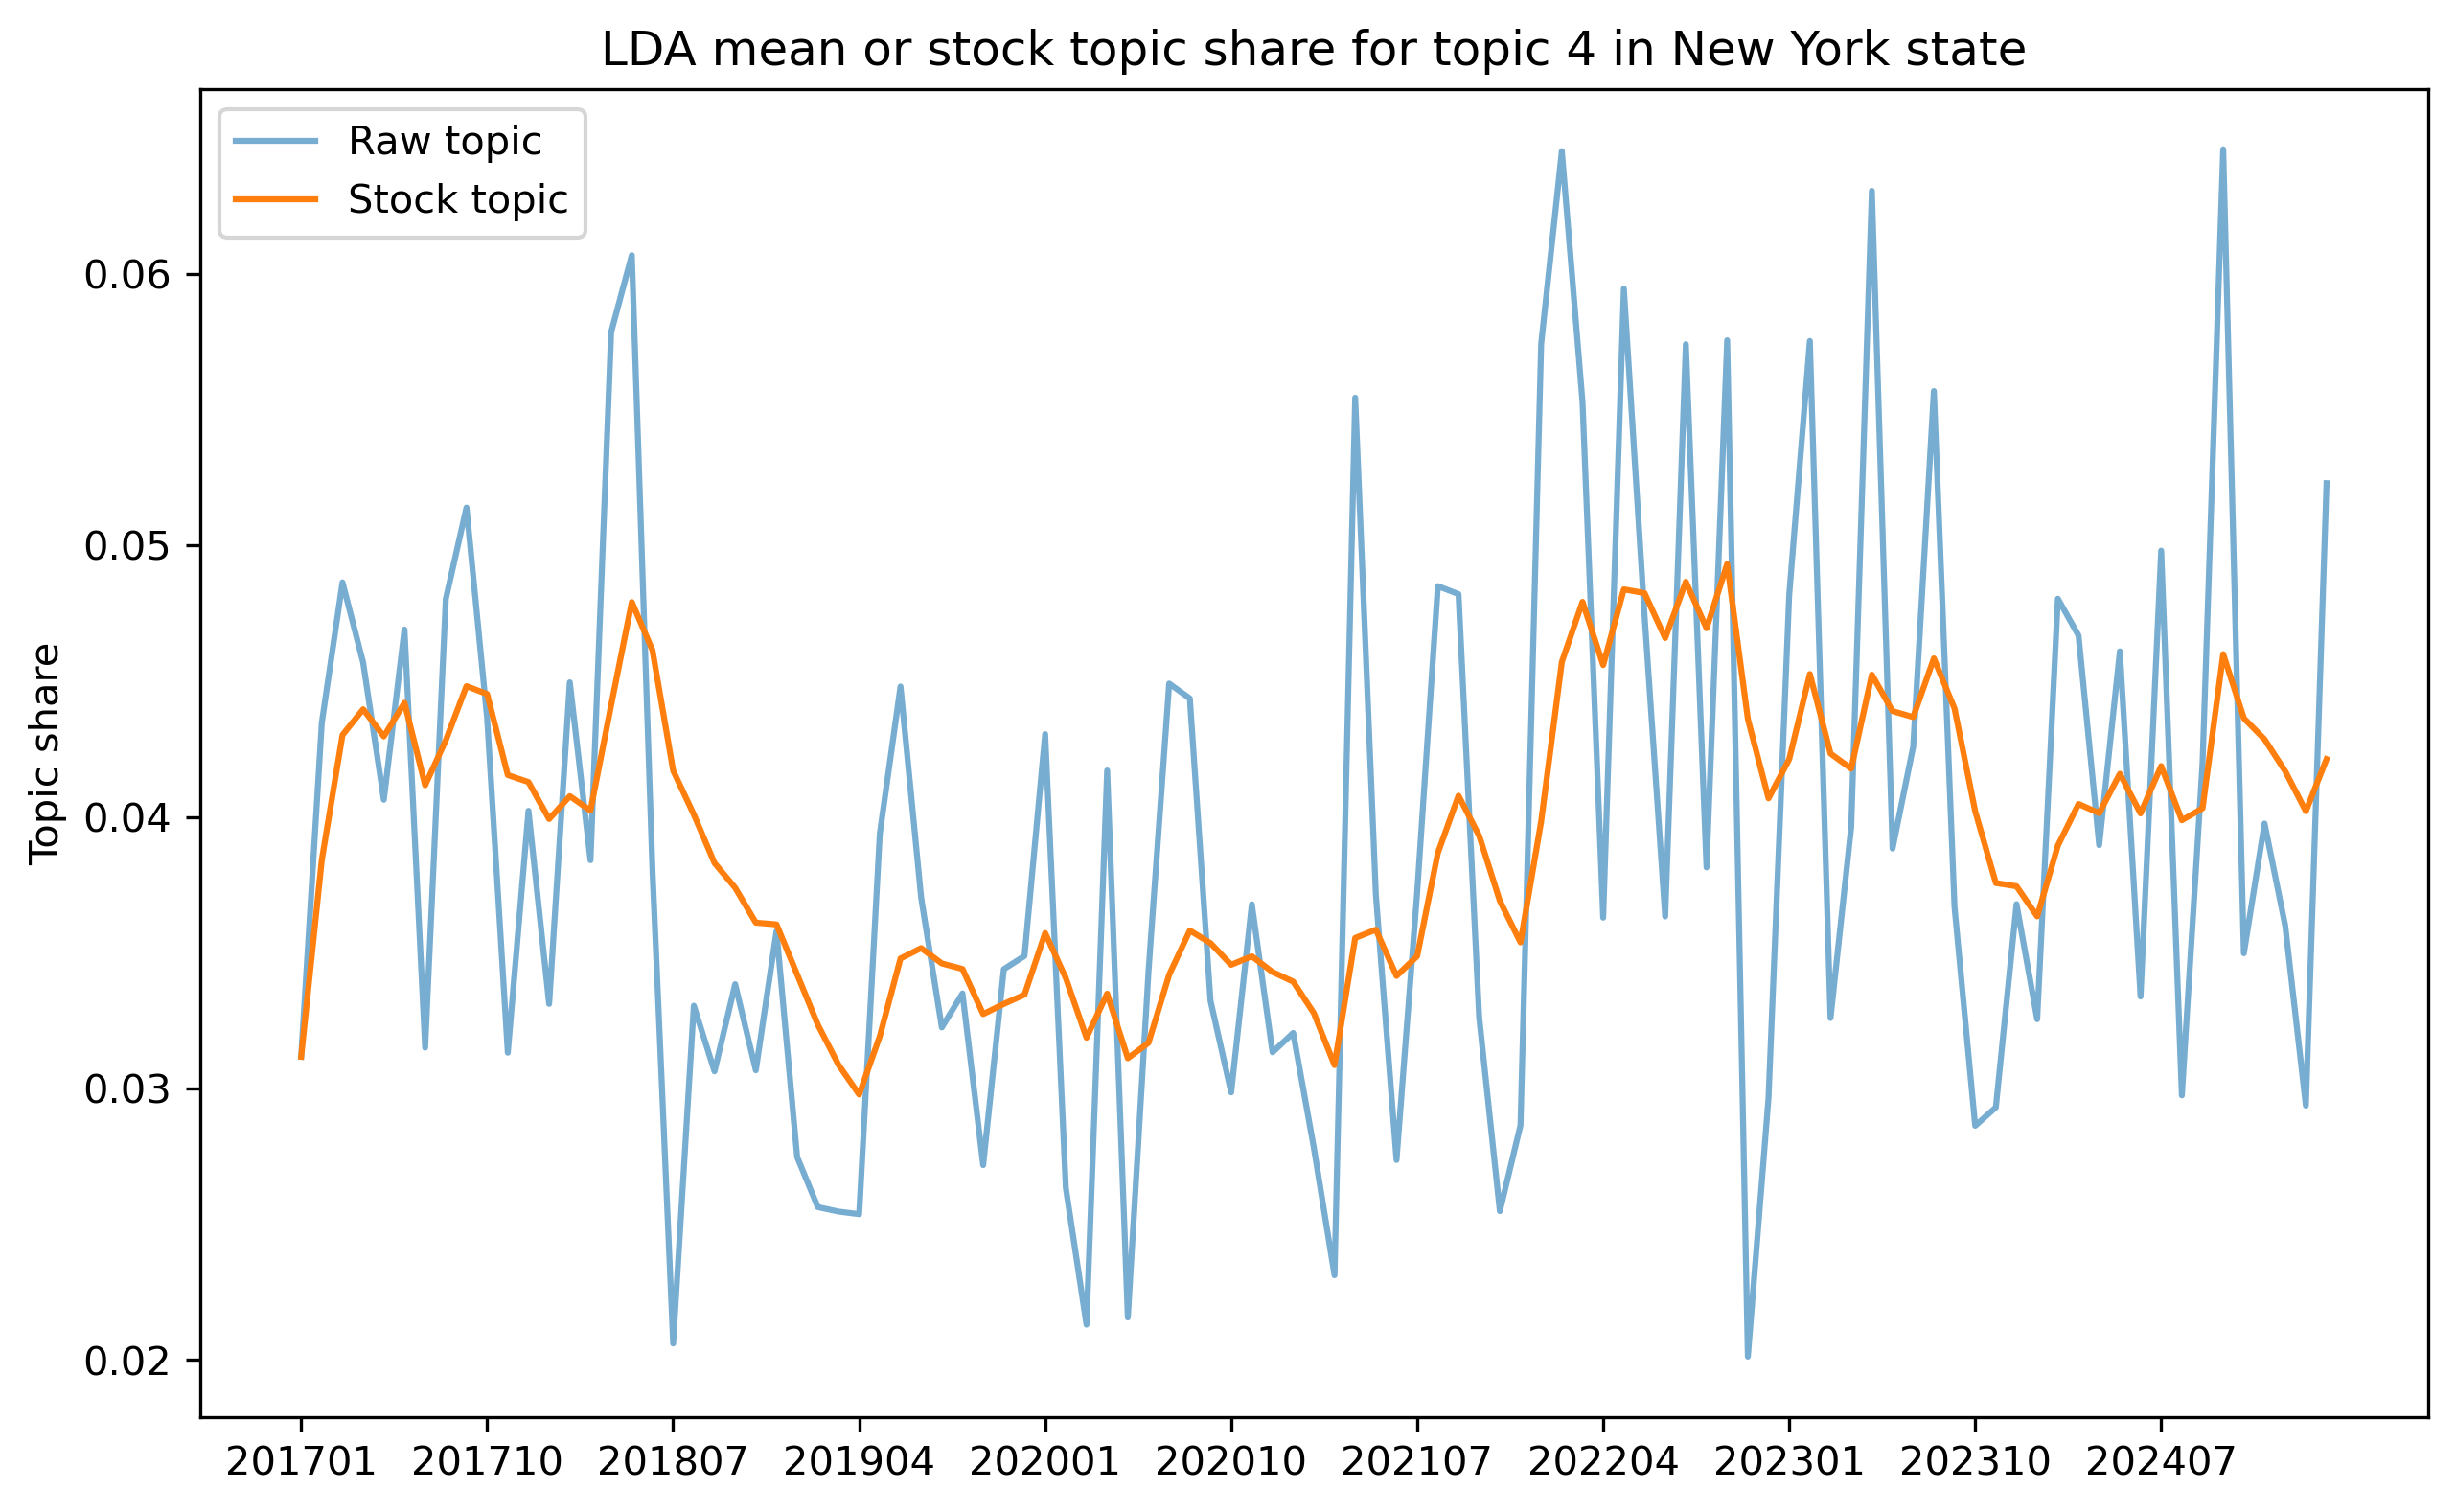

In [141]:
# Plot mean of the raw LDA topics and the stock topics

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Select just the observations for New York state (NY) (select from index)

raw_topics_ny = df_lda_agg_mean.loc['NY']
stock_topics_ny = df_lda_agg_stock.loc['NY'] 

topic_idx = 4

timesteps = pd.Index(pd.date_range(start="2017-01", periods=99, freq="MS").strftime("%Y%m"))
raw_topics_ny['plot_period'] = timesteps
stock_topics_ny['plot_period'] = timesteps

sns.lineplot(data=raw_topics_ny, x='plot_period', y=f'pr_topic_{topic_idx}', label='Raw topic', ax=ax, alpha = 0.6)
sns.lineplot(data=stock_topics_ny, x='plot_period', y=f'stock_pr_topic_{topic_idx}', label='Stock topic', ax=ax)

#set xticks every 9 months
ax.set_xticks(ticks=raw_topics_ny['plot_period'][::9])

ax.set_xlabel("")
ax.set_ylabel("Topic share")
plt.title(f"LDA mean or stock topic share for topic {topic_idx} in New York state")
plt.savefig("figures/lda_topic_aggregation_ny.png", dpi=400, bbox_inches='tight')
plt.show()

### Saving the two aggregation methods as .csv

In [ ]:
df_lda_agg_mean.to_csv('../clean_data/features/lda_shares_us/lda_agg_mean.csv')
df_lda_agg_stock.to_csv('../clean_data/features/lda_shares_us/lda_agg_stock.csv')

# 2. Loading the pre-processed data

In [3]:
df_lda_agg_stock = pd.read_csv('../clean_data/features/lda_shares_us/lda_agg_stock.csv')

df_lda_agg_stock.head()

,state,period,tokens,article_count,token_stock,stock_pr_topic_0,stock_pr_topic_1,stock_pr_topic_2,stock_pr_topic_3,stock_pr_topic_4,stock_pr_topic_5,stock_pr_topic_6,stock_pr_topic_7,stock_pr_topic_8,stock_pr_topic_9,stock_pr_topic_10,stock_pr_topic_11,stock_pr_topic_12,stock_pr_topic_13,stock_pr_topic_14
0,AK,201701,2226.0,13,2226.0000,0.051113,0.097180,0.029021,0.051774,0.105650,0.069980,0.048580,0.164622,0.019698,0.017215,0.061863,0.009229,0.161179,0.013923,0.098973
1,AK,201702,3876.0,18,5656.8000,0.168834,0.048007,0.044735,0.041778,0.050353,0.060056,0.083743,0.159661,0.008003,0.006701,0.042831,0.018224,0.216510,0.015655,0.034910
2,AK,201703,5125.0,20,9650.4400,0.143892,0.046347,0.028465,0.027687,0.072717,0.055062,0.116458,0.159897,0.005196,0.005761,0.054533,0.010443,0.225568,0.012891,0.035084
3,AK,201704,6214.0,22,13934.3520,0.100407,0.057656,0.020909,0.024063,0.067274,0.078466,0.122143,0.113848,0.005452,0.004213,0.065199,0.008170,0.281887,0.026225,0.024089
4,AK,201705,5464.0,28,16611.4816,0.079710,0.050291,0.017649,0.024871,0.081926,0.064973,0.167928,0.094136,0.009029,0.004802,0.048415,0.008420,0.231442,0.055474,0.060935


In [6]:
print('Unique states:', df_lda_agg_stock['state'].unique())

print(f'Number of unique states: {df_lda_agg_stock["state"].nunique()}')

Unique states: ['AK' 'AL' 'AR' 'AS' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'GU' 'HI'
 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MP'
 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA'
 'PR' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VI' 'VT' 'WA' 'WI' 'WV' 'WY']
Number of unique states: 56


Which are the states above that are not US states per se (outer territories, like Puerto Rico)?

In [7]:
# United States Postal Service (USPS) abbreviations.
abbreviations = [
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
    "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
    "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
    "WV", "WY",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC"
]

In [8]:
print(f'Unique states not part of the USPS list: {set(df_lda_agg_stock["state"].unique()) - set(abbreviations)}')

Unique states not part of the USPS list: {'GU', 'MP', 'AS', 'PR', 'VI'}


These territories are *GU* (Guam), *MP* (Northern Mariana Islands), *AS* (American Samoa), *PR* (Puerto Rico), *VI* (US Virgin Islands).